# Micromagnetic standard problem 4

**Author**: Marijan Beg

**Date**: 27 September 2016

## Problem specification

The simulated sample is a thin film cuboid with dimensions:
- length $L = 500 \,\text{nm}$,
- width $d = 125 \,\text{nm}$, and
- thickness $th = 3 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.02$.

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for the external magnetic field $\mathbf{B} = (-24.6, 4.3, 0.0) \,\text{mT}$.

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

## Simulation

In [19]:
!rm -rf standard_problem4/

We set all the necessary simulation parameters.

In [20]:
import numpy as np

mu0 = 4*np.pi*1e-7  # magnetic constant (H/m)

# Sample parameters
L = 500e-9  # x dimension of the sample(m)
d = 150e-9  # y dimension of the sample (m)
th = 3e-9  # sample thickness (m)

cellsize = (2.5e-9, 2.5e-9, 3e-9)  # mesh discretisation (m)

# Material (permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

# Dynamics parameters
gamma = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.02  # Gilbert damping

## First stage

In the first stage, we relax the system at zero external magnetic field.

Required packages are imported:

In [21]:
import discretisedfield as df
import oommfc as oc

Firstly, we create the system object with "standard_problem4" name.

In [22]:
system = oc.System(name='standard_problem4')

In order to fully define the micromagnetic system, we need to provide:

1. mesh,
2. hamiltonian $\mathcal{H}$,
3. dynamics equation $\text{d}\mathbf{m}/\text{d}t$, and
4. magnetisation configuration $\mathbf{m}$.

The mesh is created as follows.

In [23]:
mesh = oc.Mesh((0, 0, 0), (L, d, th), cellsize)  # Create a mesh object.

We can visualise the domain and discretisation cell

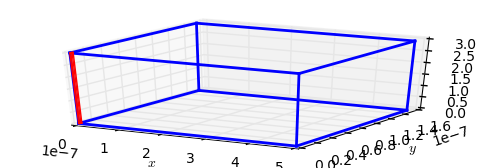

In [24]:
mesh

We now provide the mesh to the previously created system object.

In [25]:
system.mesh = mesh

In the second step, we define the systems Hamiltonian. In this standard problem, the Hamiltonian contains exchange and demagnetisation energy terms.

In [26]:
system.hamiltonian = oc.Exchange(A) + oc.Demag()

We can check what is the continuous model of system's hamiltonian.

In [27]:
system.hamiltonian

Exchange(A=1.3e-11) + Demag()

Similarly, the system's dynamics is defined by providing precession and damping terms (LLG equation).

In [28]:
system.dynamics = oc.Precession(gamma) + oc.Damping(alpha)

system.dynamics  # check the dyanamics equation

Precession(gamma=221100.0) + Damping(alpha=0.02)

Finally, we have to provide the (initial) magnetisation configuration. We choose the uniform configuration in $(1, 0.25, 0.1)$ direction, so that the norm is $M_\text{s}$ at all mesh cells.

In [29]:
system.m = df.Field(mesh, value=(1, 0.25, 0.1), normalisedto=Ms)

Now, the system is fully defined. The system (its magnetisation) is evolved using a particular driver. In the first stage, we need to relax the system - minimise its energy. Therefore, we create `MinDriver` object and drive the system using its `drive` method.

In [30]:
md = oc.MinDriver()
md.drive(system)

The system is now relaxed. We can now obtain some data characteristic to the magnetisation.

In [31]:
print('The average magnetisation is {}.'.format(system.m.average()))

c = (250e-9, 75e-9, 1e-9)
print('The magnetisation at point {} is {}.'.format(c, system.m(c)))

The average magnetisation is (0.95345218435843693, 0.15575620209990065, 7.1535427791398627e-12).
The magnetisation at point (2.5e-07, 7.5e-08, 1e-09) is [  9.99917531e-01  -1.28425557e-02  -3.72942009e-10].


## Second stage

In the second stage, we need to add an external magnetic field $\mathbf{B} = (-24.6, 4.3, 0.0) \,\text{mT}$.

In [32]:
# Add Zeeman energy.
B = np.array([-24.6, 4.3, 0.0])*1e-3
H = B/mu0 
system.hamiltonian += oc.Zeeman(H)

If we now inspect the hamiltonian, we see that an additional Zeeman term is added.

In [33]:
system.hamiltonian

Exchange(A=1.3e-11) + Demag() + Zeeman(H=[-19576.0580003    3421.83127648      0.        ])

Finally, we can run the simulation using `TimeDriver` this time. We run the magnetisation evolution for $t=1 \,\text{ns}$ and save the system's state $n=200$ times.

In [34]:
t = 1e-9
n = 200

td = oc.TimeDriver()
td.drive(system, t=t, n=n)

## Postprocessing

A detailed table of all computed parameters from the multiple stage simulation can be shown from the datatable (dt), which is pandas dataframe.

In [37]:
print(type(system.dt))
system.dt.head(10)

<class 'pandas.core.frame.DataFrame'>


,E,Ecount,max_dm/dt,dE/dt,deltaE,Eex,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,Ed,FixedZeeman:zeeman:Energy,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,4.858638e-18,121.0,3016.386663,-1.478703e-09,-4.685732e-22,1.376836e-19,3.323781,4.275831,4.275831,6.292566e-19,4.091697e-18,20.0,20.0,0.0,0.951919,0.159432,-0.006911,3.184863e-13,5.000000e-12
1,4.852787e-18,212.0,2392.751401,-9.936199e-10,-1.642942e-22,1.352755e-19,2.844454,3.391286,4.275831,6.439171e-19,4.073594e-18,36.0,15.0,1.0,0.949138,0.166909,-0.013684,1.645789e-13,1.000000e-11
2,4.848414e-18,297.0,1854.995563,-8.392113e-10,-2.067029e-22,1.373872e-19,2.734690,3.012919,4.275831,6.678010e-19,4.043226e-18,51.0,14.0,2.0,0.944407,0.179083,-0.020293,2.466902e-13,1.500000e-11
3,4.844263e-18,376.0,1711.277371,-8.837436e-10,-1.404603e-22,1.444230e-19,2.546926,2.734690,4.275831,6.997988e-19,4.000041e-18,65.0,13.0,3.0,0.937559,0.195697,-0.026721,1.592780e-13,2.000000e-11
4,4.839530e-18,449.0,1482.541737,-1.050661e-09,-4.309995e-22,1.545133e-19,2.416139,2.546926,4.275831,7.416860e-19,3.943330e-18,78.0,12.0,4.0,0.928377,0.216438,-0.032936,4.174218e-13,2.500000e-11
5,4.833734e-18,516.0,1345.288400,-1.299105e-09,-4.973159e-22,1.667280e-19,2.433104,2.492510,4.275831,7.946762e-19,3.872330e-18,90.0,11.0,5.0,0.916625,0.240937,-0.038900,3.871045e-13,3.000000e-11
6,4.826545e-18,583.0,1237.513110,-1.598135e-09,-2.781907e-22,1.802433e-19,2.441608,2.517128,4.275831,8.599827e-19,3.786319e-18,102.0,11.0,6.0,0.902065,0.268767,-0.044581,1.746679e-13,3.500000e-11
7,4.817761e-18,650.0,1268.798892,-1.928705e-09,-2.915514e-22,1.946779e-19,2.455764,2.574955,4.275831,9.383806e-19,3.684702e-18,114.0,11.0,7.0,0.884481,0.299458,-0.049955,1.515661e-13,4.000000e-11
8,4.807270e-18,717.0,1309.238386,-2.275262e-09,-5.849467e-22,2.091796e-19,2.425313,2.467517,4.275831,1.031021e-18,3.567069e-18,126.0,11.0,8.0,0.863692,0.332507,-0.055010,2.581372e-13,4.500000e-11
9,4.795005e-18,784.0,1397.755974,-2.634170e-09,-6.843242e-22,2.250811e-19,2.594102,2.594102,4.275831,1.136830e-18,3.433094e-18,138.0,11.0,9.0,0.839537,0.367409,-0.059750,2.607190e-13,5.000000e-11


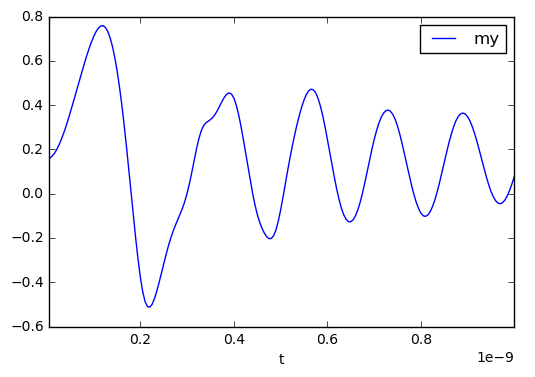

In [36]:
% matplotlib inline
myplot = system.dt.plot("t", "my")

### References
[1] http://www.ctcms.nist.gov/~rdm/mumag.org.html